# Credit

This notebook was created by Salsabila Zahirah Pranida (M2142098) and Riviawati Putri Giovani (M2992697) as a form of work in the capstone project from Bangkit.

This notebook contains preprocessing, modeling, and predicting of new datasets. The dataset was Tokopedia's product name about Foods and it classified into 7 classes: parcels, groceries, foods, cookies, snacks, frozen, and drinks. Total data have been collecting was 17,634, the data cleaned was 7,254 but imbalanced data, the data for modeling was 4956 (4212; traindata| 744; testdata)

Copyright dataset: **Tokopedia**.

# Libraries

In [ ]:
!pip install Sastrawi
!pip install contractions

In [ ]:
#import needed libraries
import re
import string
import unicodedata
import nltk
import inflect
import pickle
import contractions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, initializers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Concatenate, Input, Embedding, LSTM, Attention, Dense, Dropout, Bidirectional, LSTM, Flatten, Conv1D, GlobalMaxPool1D, MaxPool1D, Reshape, GlobalAveragePooling1D, UpSampling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from datetime import datetime

from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional, GRU, GlobalMaxPool1D
from keras.utils.np_utils import to_categorical
from keras.backend import clear_session

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load data
df = pd.read_excel('/content/drive/Shareddrives/Bangkit Capstone/Data/dataset.xlsx')
df.head()

,context,labels
0,Box of 6 waffles Mixed (kecuali Red Velvet),parcels
1,jinjja Kimchi 1Kg fresh hand made asli buatan ...,groceries
2,"Kimchi Fresh Homemade 1 Kg - Bubble Wrap, Utuh...",groceries
3,dimsum/somay/siomay isi ayam - halal,foods
4,"MULTIGRAIN, 500G",cookies


In [ ]:
#checking duplicate data
df.duplicated().sum()

1424

In [ ]:
#delete duplicated data
df = df.drop_duplicates()
df.duplicated().sum()

In [ ]:
df = df.reset_index(drop=True)
df.head()

In [ ]:
#convert label string to categorical
df.dropna(inplace = True)
df['label_id'] = df['labels'].factorize()[0]
kategori_id = df[['labels', 'label_id']].drop_duplicates().sort_values('label_id')
kategori_to_id = dict(kategori_id.values)
id_to_kategori = dict(kategori_id[['label_id', 'labels']].values)

#show data id_to_kategori
id_to_kategori

{0: 'parcels',
 1: 'groceries',
 2: 'foods',
 3: 'cookies',
 4: 'snacks',
 5: 'frozen',
 6: 'drinks'}

foods        1339
groceries    1319
snacks       1214
cookies       990
parcels       885
drinks        791
frozen        708
Name: labels, dtype: int64

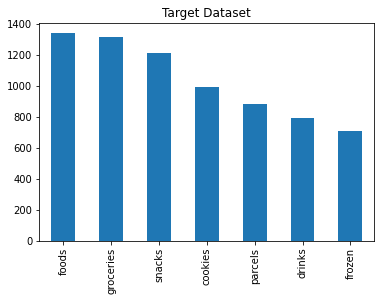

In [ ]:
#knowing dataset counts
target = df['labels'].value_counts()
target.plot(kind='bar', title='Target Dataset')

#show dataset
target

Random samping: 
3    708
6    708
2    708
5    708
1    708
4    708
0    708
Name: label_id, dtype: int64


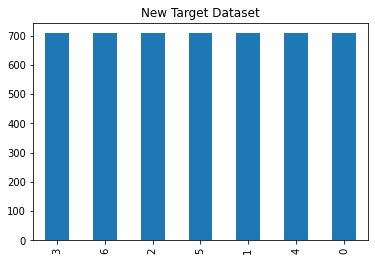

In [ ]:
#balancing dataset
class_0, class_1, class_2, class_3, class_4, class_5, class_6 = df['label_id'].value_counts()

dataset_class_0 = df[df['label_id'] == 0]
dataset_class_1 = df[df['label_id'] == 1]
dataset_class_2 = df[df['label_id'] == 2]
dataset_class_3 = df[df['label_id'] == 3]
dataset_class_4 = df[df['label_id'] == 4]
dataset_class_5 = df[df['label_id'] == 5]
dataset_class_6 = df[df['label_id'] == 6]

#making dataset as much as label 6
dataset_class_0 = dataset_class_0.sample(class_6)
dataset_class_1 = dataset_class_1.sample(class_6)
dataset_class_2 = dataset_class_2.sample(class_6)
dataset_class_3 = dataset_class_3.sample(class_6)
dataset_class_4 = dataset_class_4.sample(class_6)
dataset_class_5 = dataset_class_5.sample(class_6)
dataset_class_6 = dataset_class_6.sample(class_6)
df = pd.concat([dataset_class_0, dataset_class_1, dataset_class_2, 
                     dataset_class_3, dataset_class_4, dataset_class_5, dataset_class_6], axis=0)

print("Random samping: ")
print(df.label_id.value_counts())

df.label_id.value_counts().plot(kind='bar', title='New Target Dataset')

In [ ]:
len(df)

4956

# Preprocessing

In [ ]:
#removes html
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()
  
#remove between square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#eliminates contractions
def replace_contractions(text):
  """Replace contactions in string of text"""
  return contractions.fix(text)

#denoise text
def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  text = replace_contractions(text)
  return text

In [ ]:
#remove stopword
def removeStopword(str):
    stop_words = set(stopwords.words('indonesian'))
    word_tokens = word_tokenize(str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

In [ ]:
#cleaning dataset
def cleaning(str):
    #remove non-ascii
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    str = re.sub("b'|b\"",'',str)
    #remove username inside brackets
    str = re.sub('SENSITIVE-NO',' ',str) 
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    str = str.lower()
    return str

In [ ]:
#preprocessing dataset function
def preprocessing(str):
  str = denoise_text(str)
  str = cleaning(str)
  str = removeStopword(str)
  return str

In [ ]:
#testing preprocessing funtion
print(preprocessing('Gelatine Sheet (Bronze) / Gelatine lembaran HALAL (PER 5 LEMBAR)'))
print(preprocessing('PROMO Fresh Kimchi Korea + box plastik 1kg (bs pilih varian) Halal'))
print(preprocessing('LAKCIE KERING 250G/ DRIED CHESTNUT/LAKCI/LIZI/KACANG BERANGAN/ LAK CI'))
print(preprocessing('NASI BAKAR ENAK... (PORSI PASTI KENYAANG)'))
print(preprocessing('ARUM MANIS RAMBUT NENEK KEMASAN 650ML/arumanis/aromanis/arbanat/GULALI'))
print(preprocessing('[BTL] Kobe Boncabe Level 15 Original BOTOL Sambal Tabur | Bon Cabe'))

gelatine sheet bronze gelatine lembaran halal lembar
promo fresh kimchi korea box plastik bs pilih varian halal
lakcie kering dried chestnut lakci lizi kacang berangan lak ci
nasi bakar enak porsi kenyaang
arum manis rambut nenek kemasan arumanis aromanis arbanat gulali
kobe boncabe level original botol sambal tabur bon cabe


In [ ]:
#apply preprocessing
df['text'] = df['context'].apply(preprocessing)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4956 entries, 5925 to 4545
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   4956 non-null   object
 1   labels    4956 non-null   object
 2   label_id  4956 non-null   int64 
 3   text      4956 non-null   object
dtypes: int64(1), object(3)
memory usage: 193.6+ KB


In [ ]:
len(df)

4956

In [ ]:
df

,context,labels,label_id,text
5925,parcel buah tanpa tangkai/pegangan,parcels,0,parcel buah tangkai pegangan
204,SEMBAKO MURAH BERKUALITAS!,parcels,0,sembako murah berkualitas
5987,"Parsel Ramadan Custom Cilok Djoedes, Healthy C...",parcels,0,parsel ramadan custom cilok djoedes healthy ce...
5866,"PARCEL SPESIAL LEBARAN MURAH, MEWAH DAN BERKUA...",parcels,0,parcel spesial lebaran murah mewah berkualitas...
2416,PAKET COKLAT PRIORITAS DREAM BELLAROSA BINGKIS...,parcels,0,paket coklat prioritas dream bellarosa bingkis...
...,...,...,...,...
4505,Madu Uray - Honey - Murni - Sehat - Madu Alami...,drinks,6,madu uray honey murni sehat madu alami
2006,Chocodrink Minuman Cokelat 28 gr x 5 sachet,drinks,6,chocodrink minuman cokelat gr x sachet
4692,Morning Rice 180ml kaleng - Makgeolli - Makoli...,drinks,6,morning rice kaleng makgeolli makoli air beras...
2022,Sari Lemon / Air Lemon Murni / Pure lemon Juic...,drinks,6,sari lemon air lemon murni pure lemon juice be...


# Modelling

In [ ]:
#checking dataset value
label = df['label_id'].values
text = df['text'].values

print('Value of [label_id]:', label, "\n")
print('Value of [text]:', text)

Value of [label_id]: [0 0 0 ... 6 6 6] 

Value of [text]: ['parcel buah tangkai pegangan' 'sembako murah berkualitas'
 'parsel ramadan custom cilok djoedes healthy cendol frozen food' ...
 'morning rice kaleng makgeolli makoli air beras korea'
 'sari lemon air lemon murni pure lemon juice beorganik'
 'vinega cuka apel apple cider vinegar']


In [ ]:
#max features
maxfeatures = 20000

#tokenization
tokenizer = Tokenizer(num_words = maxfeatures)
tokenizer.fit_on_texts(text)

In [ ]:
#max sequential per word in NN
maxseqlen = max([len(i.split()) for i in text])
print(maxseqlen)

14


In [ ]:
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, maxlen = maxseqlen)
y = to_categorical(label, num_classes = 7)

print("Shape of data tensor ['text']:", X.shape)
print("Shape of data tensor ['label']:", y.shape)

Shape of data tensor ['text']: (4956, 14)
Shape of data tensor ['label']: (4956, 7)


In [ ]:
#tokening word index
tokenizer.word_index

{'frozen': 1,
 'paket': 2,
 'madu': 3,
 'asli': 4,
 'isi': 5,
 'hampers': 6,
 'kue': 7,
 'lebaran': 8,
 'ayam': 9,
 'parcel': 10,
 'original': 11,
 'kg': 12,
 'gram': 13,
 'premium': 14,
 'goreng': 15,
 'gr': 16,
 'kacang': 17,
 'murah': 18,
 'buah': 19,
 'khas': 20,
 'bawang': 21,
 'beku': 22,
 'kering': 23,
 'cookies': 24,
 'sapi': 25,
 'bumbu': 26,
 'manis': 27,
 'halal': 28,
 'pcs': 29,
 'murni': 30,
 'box': 31,
 'gula': 32,
 'daging': 33,
 'sembako': 34,
 'ikan': 35,
 'bubuk': 36,
 'pedas': 37,
 'parsel': 38,
 'kentang': 39,
 'keju': 40,
 'super': 41,
 'coklat': 42,
 'honey': 43,
 'sambal': 44,
 'roti': 45,
 'as': 46,
 'mix': 47,
 'chicken': 48,
 'ml': 49,
 'keripik': 50,
 'pempek': 51,
 'lemon': 52,
 'termurah': 53,
 'cake': 54,
 'merah': 55,
 'bali': 56,
 'sari': 57,
 'idul': 58,
 'fitri': 59,
 'panggang': 60,
 'enak': 61,
 'kulit': 62,
 'babi': 63,
 'beef': 64,
 'free': 65,
 'rendang': 66,
 'almond': 67,
 'by': 68,
 'food': 69,
 'al': 70,
 'ramadan': 71,
 'nastar': 72,
 'udang'

In [ ]:
#determine vocab data used
vocab = max([len(tokenizer.word_index)]) + 1
vocab

4078

In [ ]:
#initializer
initializer = initializers.RandomUniform(minval = -0.05, maxval = 0.05, seed = 2)

In [ ]:
#split dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.15, random_state = 128)

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

(4212, 14) (4212, 7)
(744, 14) (744, 7)


In [ ]:
#architecture model
model = Sequential()
model.add(Embedding(input_dim = maxfeatures, output_dim = 128, input_length = maxseqlen, embeddings_initializer = initializer))
model.add(Bidirectional(GRU(200, return_sequences = True, kernel_initializer = initializer)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 128)           2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 400)           396000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 400)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               205312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [ ]:
#declare checkpoint variable and early stopping to get best model
file_path = 'save_best'
checkpoint = ModelCheckpoint(file_path, monitor = 'val_acc', verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [ ]:
#training model
start_time = datetime.now()
history = model.fit(Xtrain, ytrain,
                    batch_size = 64, epochs = 25, shuffle = True,
                    validation_split = 0.1, verbose = 1)
end_time = datetime.now()
print("Time out: {}".format(end_time - start_time))

Epoch 1/25
60/60 [==============================] - 12s 132ms/step - loss: 1.8953 - accuracy: 0.1893 - val_loss: 1.2330 - val_accuracy: 0.6280
Epoch 2/25
60/60 [==============================] - 7s 114ms/step - loss: 0.9552 - accuracy: 0.6430 - val_loss: 0.6265 - val_accuracy: 0.7749
Epoch 3/25
60/60 [==============================] - 7s 113ms/step - loss: 0.5230 - accuracy: 0.8329 - val_loss: 0.5369 - val_accuracy: 0.8460
Epoch 4/25
60/60 [==============================] - 7s 114ms/step - loss: 0.3261 - accuracy: 0.9131 - val_loss: 0.6392 - val_accuracy: 0.8270
Epoch 5/25
60/60 [==============================] - 7s 114ms/step - loss: 0.2422 - accuracy: 0.9328 - val_loss: 0.5777 - val_accuracy: 0.8341
Epoch 6/25
60/60 [==============================] - 7s 114ms/step - loss: 0.1739 - accuracy: 0.9521 - val_loss: 0.6619 - val_accuracy: 0.8389
Epoch 7/25
60/60 [==============================] - 7s 113ms/step - loss: 0.1441 - accuracy: 0.9605 - val_loss: 0.7004 - val_accuracy: 0.8507
Epoch

In [ ]:
#build eveluation function
def evaluation(model, X, Y):
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    rounded_labels=np.argmax(Y, axis=1)
    Y_act = rounded_labels
    
    accuracy = accuracy_score(Y_act, Y_pred_class)
    return accuracy

In [ ]:
accuracy = evaluation(model, Xtest, ytest)
print('accuracy: %.3f' % (accuracy * 100), '%')

accuracy: 85.484 %


In [ ]:
import pickle
with open('/content/drive/Shareddrives/Bangkit Capstone/ml dev/model/bangkitcapstone.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('/content/drive/Shareddrives/Bangkit Capstone/ml dev/model/bangkitcapstone.h5')

# Prediction

In [ ]:
model = load_model('/content/drive/Shareddrives/Bangkit Capstone/ml dev/model/bangkitcapstone.h5')

In [ ]:
#new data
test = ['Hampers Lebaran/Idul Fitri | Suwe Ora Jamu | Healthy Digestive',
        'lada hitam seasoned kemiri BAWANG puth',
        'Ayam Kodok Special',
        'Kotak Exclusive Imlek untuk kue kering toples nastar, lidah kucing',
        'Camilan seafood kerupuk TRIPANG (mentah)',
        'Risol Kering isi bihun wortel...( mentah frozen )',
        'Milk Chocolate Drink - Coklat Cocoa Bubuk | Minuman Dari Bubuk Coklat',
        'parsel lebaran idul adha kambing goreng',
        'bawang putih campuran merah',
        'tahu ikan sabu sabu bakar',
        'kastangel lebaran',
        'dimsum freeze',
        'air mineral',
        'parcel minuman oncom freeze',
        'minuman parcel freeze oncom',
        'freeze oncom parcel minuman']

#expected
#0, 1, 2, 3, 4, 5, 6
#parcels, groceries, foods, cookies, snacks, frozen, drinks

In [ ]:
#tokenizing newdata
newdata = tokenizer.texts_to_sequences(test)
newdata = pad_sequences(newdata, maxlen = maxseqlen)

In [ ]:
model_predict = model.predict(newdata)
model_label = np.argmax(model_predict, axis = 1)
model_probability = model_predict.max(axis = 1)

In [ ]:
#proccess model into prediction and probability of newdata
model_labeled = []
model_sentence = []
model_probabilities = []
for model_unlabeled, model_label, model_probability in zip(test, model_label, model_probability):
  print('"{}"'.format(model_unlabeled))
  u = model_unlabeled
  l = id_to_kategori[model_label]
  model_labeled.append(l)
  model_sentence.append(u)
  model_probabilities.append(model_probability)

  print("  - Prediction: '{}'".format(id_to_kategori[model_label]))
  print("  - Probability: '{}'".format(model_probability))
  print("")

"Hampers Lebaran/Idul Fitri | Suwe Ora Jamu | Healthy Digestive"
  - Prediction: 'parcels'
  - Probability: '1.0'

"lada hitam seasoned kemiri BAWANG puth"
  - Prediction: 'groceries'
  - Probability: '1.0'

"Ayam Kodok Special"
  - Prediction: 'foods'
  - Probability: '0.9834527373313904'

"Kotak Exclusive Imlek untuk kue kering toples nastar, lidah kucing"
  - Prediction: 'cookies'
  - Probability: '0.9972249269485474'

"Camilan seafood kerupuk TRIPANG (mentah)"
  - Prediction: 'snacks'
  - Probability: '0.999992847442627'

"Risol Kering isi bihun wortel...( mentah frozen )"
  - Prediction: 'frozen'
  - Probability: '0.9997090697288513'

"Milk Chocolate Drink - Coklat Cocoa Bubuk | Minuman Dari Bubuk Coklat"
  - Prediction: 'drinks'
  - Probability: '0.9962575435638428'

"parsel lebaran idul adha kambing goreng"
  - Prediction: 'parcels'
  - Probability: '1.0'

"bawang putih campuran merah"
  - Prediction: 'groceries'
  - Probability: '0.9999854564666748'

"tahu ikan sabu sabu bakar"